In [30]:
import ujson as json
import numpy as np
import pandas as pd
import gensim
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [31]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [32]:
# Load dataset

In [33]:
path = 'joined_dev_set.json'
# path = 'data/joined_dev_set.json'
with open(path) as f:
    data = json.load(f)
    df = pd.json_normalize(data)
    df = df.astype({'id': 'string'})

In [34]:
# Find max molecule_count

In [35]:
FLAVOR_VECTOR_SIZE = df['molecules_count'].max() 
FLAVOR_VECTOR_SIZE

677

In [36]:
# Construct Document vectors

In [37]:
df['molecules'] = df['flavor_molecules'].apply(lambda el: [str(m['pubchem_id']) for m in el])

In [38]:
# Build Tagged Document Corpus

In [39]:
df['doc'] = df.apply(lambda r: gensim.models.doc2vec.TaggedDocument(r['molecules'], [r['id']]), axis=1)

In [40]:
df.iloc[:5]

,id,food,unique_ingredient,ingredient_count,category_freq,instructions,flavor_molecules,molecules_count,nutr_values_per100g.energy,nutr_values_per100g.fat,nutr_values_per100g.protein,nutr_values_per100g.salt,nutr_values_per100g.saturates,nutr_values_per100g.sugars,fsa_lights_per100g.fat,fsa_lights_per100g.salt,fsa_lights_per100g.saturates,fsa_lights_per100g.sugars,molecules,doc
0,005e671ac4,Pecan Pralines,"[cream, fluid, heavy whipping, sugars, brown, ...",5,"[{'additive': 1}, {'dairy': 2}, {'fruit-essenc...",[{'text': 'Butter a medium saucepan--this will...,"[{'ingredient_flavorDB': 'Vanilla', 'fooddb_id...",261,435.964748,24.989687,2.537034,0.060941,7.789799,53.903056,red,green,red,red,"[247, 11552, 7501, 9895, 644104, 7519, 11508, ...","([247, 11552, 7501, 9895, 644104, 7519, 11508,..."
1,00703db954,Greatest Granola,"[oats, seeds, sesame seeds, whole, dried, seed...",8,"[{'additive': 1}, {'cerealcrop-cereal': 1}, {'...","[{'text': 'Preheat oven to 300F.'}, {'text': '...","[{'ingredient_flavorDB': 'Sesame', 'fooddb_id'...",306,580.155727,48.485788,3.756246,0.021983,29.293118,15.443671,red,green,red,red,"[5283335, 439246, 72, 5283329, 180, 8130, 4393...","([5283335, 439246, 72, 5283329, 180, 8130, 439..."
2,007e544c80,Cream of Fresh Cauliflower Soup,"[soup, chicken broth or bouillon, dry, onions,...",9,"[{'additive': 1}, {'cerealcrop-cereal': 1}, {'...","[{'text': 'In a saucepan, combine the chicken ...","[{'ingredient_flavorDB': 'Milk', 'fooddb_id': ...",506,67.292099,2.138987,2.653950,6.092506,0.857253,4.552126,green,red,green,green,"[985, 261, 7288, 643941, 439341, 8103, 62367, ...","([985, 261, 7288, 643941, 439341, 8103, 62367,..."
3,00a0ea8691,Sausage and Rice Bake,"[rice, white, long-grain, regular, unenriched,...",9,"[{'additive': 1}, {'cerealcrop-cereal': 1}, {'...","[{'text': 'In a shallow 2 qt casserole, place ...","[{'ingredient_flavorDB': 'Rice', 'fooddb_id': ...",470,123.633639,10.130253,3.196904,2.174727,1.179480,2.788862,orange,red,green,green,"[10393, 6140, 442501, 18698, 33931, 65575, 615...","([10393, 6140, 442501, 18698, 33931, 65575, 61..."
4,00deb3f9f4,Spicy Raspberry Balsamic Dressing,"[oil, olive, salad or cooking, vinegar, balsam...",9,"[{'additive': 1}, {'fruit-berry': 1}, {'nutsee...","[{'text': 'Whisk olive oil, balsamic vinegar, ...","[{'ingredient_flavorDB': 'Raspberry', 'fooddb_...",462,569.663693,60.804892,0.379360,1.489440,8.426000,5.014039,red,orange,red,orange,"[5282708, 637511, 10931, 998, 14896, 7460, 722...","([5282708, 637511, 10931, 998, 14896, 7460, 72..."


In [41]:
# Train Model

In [42]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, window=FLAVOR_VECTOR_SIZE, epochs=40)
model.build_vocab(df['doc'])

2021-11-21 18:05:10,170 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow,d300,n5,mc5,s0.001,t3)', 'datetime': '2021-11-21T18:05:10.169984', 'gensim': '4.0.1', 'python': '3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'created'}
2021-11-21 18:05:10,171 : INFO : collecting all words and their counts
2021-11-21 18:05:10,172 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-21 18:05:10,252 : INFO : collected 1399 word types and 1000 unique tags from a corpus of 1000 examples and 311515 words
2021-11-21 18:05:10,254 : INFO : Creating a fresh vocabulary
2021-11-21 18:05:10,262 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1300 unique words (92.92351679771265%% of original 1399, drops 99)', 'datetime': '2021-11-21T18:05:10.262333', 'gensim': '4.0.1', 'python': '3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 

In [43]:
model.train(df['doc'], total_examples=model.corpus_count, epochs=model.epochs)

2021-11-21 18:05:10,311 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 1300 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=677', 'datetime': '2021-11-21T18:05:10.311411', 'gensim': '4.0.1', 'python': '3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'train'}
2021-11-21 18:05:10,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-21 18:05:10,617 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-21 18:05:10,624 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-21 18:05:10,626 : INFO : EPOCH - 1 : training on 311515 raw words (304605 effective words) took 0.3s, 996798 effective words/s
2021-11-21 18:05:10,915 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-21 18:05:10,934 : INFO : worker thread finished; awaiting finish of 1 more threads
2

In [44]:
# Search for similar flavor vecotrs

In [45]:
def random_suggestion():
    row = df.sample(n=1)
    flavor_vec = model.infer_vector(row.iloc[0]['doc'].words)
    similars = model.dv.most_similar(positive=[flavor_vec]) ## revised here, error "cannot unpack non-iterable numpy.float32 object"
    s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
    return pd.concat([row[['id','food']], s_df.merge(df, on='id', how='left')[['id','similarity','food']] ])

In [64]:
random_suggestion()

,id,food,similarity
497,86f886d030,Maple Watermelon and Pineapple Popsicles,NaN
0,86f886d030,Maple Watermelon and Pineapple Popsicles,0.930880
1,3bdbee3d42,Honeydew and Pineapple Pops,0.837583
2,92823d6f0e,Surfin' Safari Fruit Smoothie,0.701127
3,fe3ae983b8,Watermelon Strawberry Lemonade,0.692890
4,03406b8942,Rosy Pineapple Ice,0.650577
5,6ad4d5c25e,Melon-Papaya Batido,0.626530
6,98d850bf92,The Frenchy Cocktail,0.616670
7,e43c2efc4e,Peachy Pineapply Smoothie,0.602642
8,dbda89a5af,Homemade Pectin,0.581424


In [47]:
# Dimenstional Reduction

In [48]:
import umap.umap_ as umap

In [49]:
reducer = umap.UMAP()
projection = reducer.fit_transform(model.dv.vectors) # model.dv.index_to_key 
projection

array([[ 6.762953 ,  3.359264 ],
       [ 8.695068 ,  7.171839 ],
       [10.308887 , 10.380794 ],
       ...,
       [12.0991745,  6.1505003],
       [ 7.9554195,  3.1771193],
       [ 9.910322 , 11.788412 ]], dtype=float32)

In [50]:
# Visualize Flavor Space

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.layouts import column
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Callback, DataTable, TableColumn,\
CustomJS, TextInput, Circle
from bokeh.palettes import Spectral10
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20


sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
output_notebook()

Loading BokehJS ...

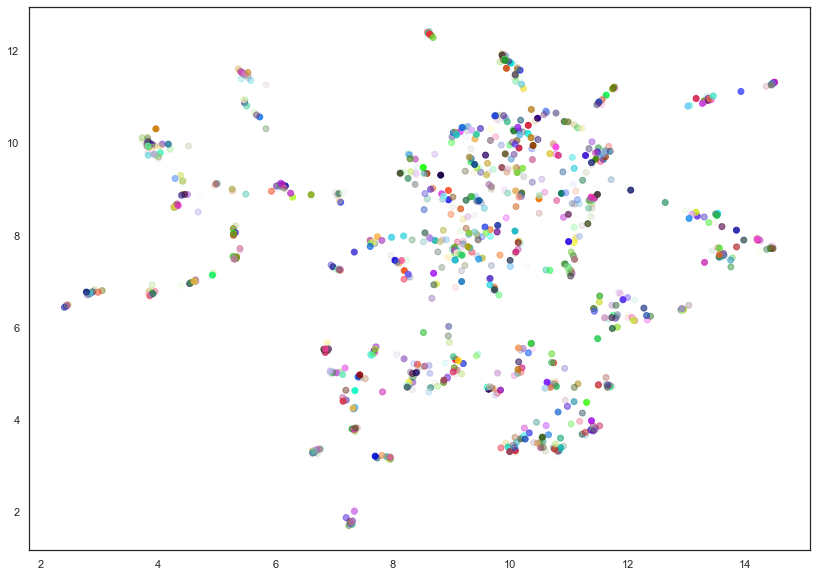

In [52]:
colors = np.random.rand(projection.shape[0], 4)
plt.scatter(projection[:,0], projection[:,1], c=colors)

In [53]:
projection_df = pd.DataFrame(projection, columns=('x', 'y'))
projection_df['id'] = model.dv.index_to_key
projection_df['food'] = df['food']
projection_df['ingredient'] = df['unique_ingredient']
projection_df['ingredient_count'] = df['ingredient_count']
selected_indexes = []

In [54]:
projection_df[projection_df['ingredient_count'] <= 2]

,x,y,id,food,ingredient,ingredient_count
23,11.119958,7.937233,05f3f4e20a,Lemonade-Cayenne Frozen Dessert,"[lemonade, frozen concentrate, white, prepared...",2
100,6.979559,7.312103,19e9a4d0f2,Balsamic Drizzle,"[vinegar, balsamic, sugars, brown]",2
108,6.870844,5.535427,1b5b8a1d6a,Homemade Cocktail Sauce,"[catsup, horseradish, prepared]",2
120,7.116429,8.766646,1e69651aae,Pooh's Honey Sauce 1,"[honey, cream, whipped, cream topping, pressur...",2
127,9.057686,7.741402,20524e7341,Homemade Whip Cream,"[cream, fluid, heavy whipping, sugars, powdered]",2
...,...,...,...,...,...,...
942,8.912138,7.898773,f2bdd4fb30,Pan-Roasted Chestnuts Recipe,"[nuts, chestnuts, european, dried, peeled, wat...",2
943,11.756999,11.185729,f2ea268610,Roast Pork Shoulder,"[pork, fresh, loin, tenderloin, separable lean...",1
949,7.086048,7.246354,f4dd72ff5e,Almond Joy Recipe,"[shortening confectionery, coconut (hydrogenat...",2
964,4.609436,6.997049,f7eaa1064a,Chocolate and Milk,"[spartan, real semi-sweet chocolate baking chi...",2


In [66]:
def findSimilars(food="chicken wing", limit=0):
    i=3
    copy = df.loc[:, ['id', "food", "ingredient_count"]]
    copy["ratio"] = copy['food'].apply(lambda x : fuzz.partial_ratio(x, [food]))
    copy = copy.sort_values(by=["ratio"], ascending=False)
    display(copy)
    row = df.loc[df['id']==copy["id"].iloc[0]]
    flavor_vec = model.infer_vector(row.iloc[0]['doc'].words)
    similars = model.dv.most_similar(positive=[flavor_vec])
    indices = [x[0] for x in similars]
    indices.append(copy["id"].iloc[0])
    selected_df = projection_df[projection_df["id"].isin(indices)]
    selected_df = selected_df[selected_df['ingredient_count'] > limit].iloc[:10]
    nonselected_df = projection_df[~projection_df["id"].isin(selected_df['id'])]
    return nonselected_df, selected_df

In [67]:
findSimilars()[1]

,id,food,ingredient_count,ratio
206,3425dc147c,Easiest Chicken Wing Recipe,2,62
385,68d15e1d00,Sizzlin' Chicken Skewers,7,56
149,24876cef34,Outrageously good chicken potpie,10,56
396,6c26cceaf5,Sizzlin' Chicken Skewers,7,56
655,a920617c0d,Rice Milk,3,56
...,...,...,...,...
72,1443c69124,Potato Casserole,3,6
816,d5902cb842,ANDRES MINT CHOCOLATE CAKE,3,6
876,e3c03c2fed,"""GREEN TOMATO JAM""",3,6
933,f139114260,Dry Rub for Pork,7,6


,x,y,id,food,ingredient,ingredient_count
186,8.833715,8.895967,2fbf9114ed,Homemade Chicken and Dumplings,"[wheat flour, white, all-purpose, unenriched, ...",7
206,8.949615,8.766252,3425dc147c,Easiest Chicken Wing Recipe,"[chicken, broilers or fryers, wing, meat and s...",2
265,8.850082,8.775471,476f6b28cb,Chicken Quesadillas for Toddlers,"[chicken, broiler or fryers, breast, skinless,...",4
325,11.518958,6.549143,58c488f1e9,Crock Pot Orange Chicken,"[chicken, broiler or fryers, breast, skinless,...",6
377,8.869332,8.842174,669e7cfcad,Grandpa Sprague's Grilled Chicken,"[chicken, broiler or fryers, breast, skinless,...",4
401,13.444726,7.662987,6d8a9c1445,Chicken-N-Biscuits for Pups,"[chicken, broiler or fryers, breast, skinless,...",5
559,10.037451,10.012516,93c54e11f3,Chicken Almond Sandwiches Recipe,"[chicken, broiler or fryers, breast, skinless,...",4
854,10.082927,9.972971,ddfbb55c30,Armadillo Eggs,"[chicken, broiler or fryers, breast, skinless,...",3
873,9.152590,8.085537,e35bc46e21,Flaming Orgy,"[ground turkey, raw, alcoholic beverage, disti...",3
945,11.525254,6.679848,f3518c8229,Maple and Orange-Glazed Carrots,"[carrots, raw, soup, chicken broth or bouillon...",4


In [74]:
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
import bokeh.plotting.figure as bk_figure
from bokeh.io import curdoc, show
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, Text 
from bokeh.models.widgets import Slider, TextInput, Select, AutocompleteInput
from bokeh.io import output_notebook # 

In [80]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

output_notebook() ## output to the notebook, avoid using bokeh server


## config plot canvas
fig = figure(
    title='UMAP projection of the Flavor Space',
    plot_width=800,
    plot_height=700,
    tools=('pan, wheel_zoom, reset, lasso_select')
)

fig.add_tools(HoverTool(tooltips="""
                        <div>
                            <div>
                                <span style='font-size: 12px; color: #224499'>Recipe: @id</span>
                                <span style='font-size: 12px'>@food</span>
                            </div>
                        </div>
                    """
            ))


## prepare data
nonselected_df, selected_df = findSimilars()
chart_data = ColumnDataSource(nonselected_df)
highlighted_data = ColumnDataSource(selected_df)
table_data = ColumnDataSource(dict(id=highlighted_data.data["id"], 
                           food=highlighted_data.data["food"], 
                           ingredient = highlighted_data.data["ingredient"],
                           ingredient_count=highlighted_data.data["ingredient_count"]
                          ))


## drawing scatter of non selected data
mapper = linear_cmap(field_name='y',palette=Category20[4] ,low=min(projection_df['x']) ,high=max(projection_df['y']))
chart = fig.circle(
    'x',
    'y',
    source=chart_data,
    color=mapper,
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6
)
## highlight selected nodes
chart.selection_glyph = Circle(fill_alpha=1, fill_color="firebrick", line_color=None)
chart.nonselection_glyph = Circle(fill_color="black", line_color=None)

## drawing scatter of selected data in red color
highlighted_chart = fig.circle(
    'x',
    'y',
    source=highlighted_data,
    color="red",
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6
)


## display the selected data
table = DataTable(source=table_data, sizing_mode="stretch_width", columns=[
    TableColumn(field='id'),
    TableColumn(field='food'),
    TableColumn(field='ingredient'),
    TableColumn(field='ingredient_count')
])

select_callback = CustomJS(args=dict(chart_data=chart_data, table_data=table_data), 
              code="""
                var selected_indexes = cb_obj.indices;
                console.log(chart_data.data)
                table_data.data['id'] = [];
                table_data.data['food'] = [];
                table_data.data['ingredient_count'] = [];
                for (let i=0;i<selected_indexes.length;i++){
                    table_data.data['id'].push(chart_data.data['id'][selected_indexes[i]])
                    table_data.data['food'].push(chart_data.data['food'][selected_indexes[i]])
                    table_data.data['ingredient'].push(chart_data.data['ingredient'][selected_indexes[i]])
                    table_data.data['ingredient_count'].push(chart_data.data['ingredient_count'][selected_indexes[i]])
                }                
                table_data.change.emit();
                """
             )

chart_data.selected.js_on_change('indices', 
    select_callback
)


#### config user input widgets
def updateData(food, limit):
    nonselected_df, selected_df = findSimilars(text_input.value, int(select_ingredient_filter.value))
    # update data
    chart_data.data = nonselected_df
    highlighted_data.data = selected_df
    table_data.data = dict(id=highlighted_data.data["id"], 
                           food=highlighted_data.data["food"], 
                           ingredient = highlighted_data.data["ingredient"],
                           ingredient_count=highlighted_data.data["ingredient_count"]
                          )

    
## text input for food input
def text_input_callback(attr, old, new):
    updateData(text_input.value, int(select_ingredient_filter.value))
# get all possible entries
completions=df["food"].tolist()
text_input = AutocompleteInput(title="Food Name", value='chicken wing', completions=completions, case_sensitive=False)       
# text_input = TextInput(value="chicken wing", title="Food:")
text_input.on_change("value",text_input_callback)


## filtration food with only 1 or 2 ingredients
def ingredient_filter_callback(attr, old, new):
    updateData(text_input.value, int(select_ingredient_filter.value))
select_ingredient_filter = Slider(start=0, end=5, value=0, step=1, title="Food with at least N ingredients")
# select_ingredient_filter =Select(title="Food with at least N ingrediens ", value="0", options=["0", "1", "2", "3", "4", "5"])
select_ingredient_filter.on_change("value", ingredient_filter_callback)


## Nutrition Optimizer
def nutrition_filter_callback(attr, old, new):
    ###############
    #### placeholder optimization algorithm here
    ##############
    print(select_nutrition_filter.value)    
select_nutrition_filter = Select(title="Nutrition Priority", value="Protein", options=["Protein", "Fat", "Calories"])
select_nutrition_filter.on_change("value", nutrition_filter_callback)



# Set up layouts and add to document
layout = column(row(text_input, select_ingredient_filter, select_nutrition_filter),fig, table)

def modify_doc(doc):
    doc.add_root(row(layout, width=800))
    return doc


handler = FunctionHandler(modify_doc) # A Handler that accepts a plain python function to use for modifying Bokeh Documents.
app = Application(handler)
show(app)

Loading BokehJS ...

,id,food,ingredient_count,ratio
206,3425dc147c,Easiest Chicken Wing Recipe,2,62
385,68d15e1d00,Sizzlin' Chicken Skewers,7,56
149,24876cef34,Outrageously good chicken potpie,10,56
396,6c26cceaf5,Sizzlin' Chicken Skewers,7,56
655,a920617c0d,Rice Milk,3,56
...,...,...,...,...
72,1443c69124,Potato Casserole,3,6
816,d5902cb842,ANDRES MINT CHOCOLATE CAKE,3,6
876,e3c03c2fed,"""GREEN TOMATO JAM""",3,6
933,f139114260,Dry Rub for Pork,7,6


2021-11-21 19:33:15,076 : INFO : Starting Bokeh server version 2.4.1 (running on Tornado 6.1)
2021-11-21 19:33:15,080 : INFO : User authentication hooks NOT provided (default user enabled)


2021-11-21 19:33:15,195 : INFO : 200 GET /autoload.js?bokeh-autoload-element=2865&bokeh-absolute-url=http://localhost:51241&resources=none (::1) 65.83ms
INFO:tornado.access:200 GET /autoload.js?bokeh-autoload-element=2865&bokeh-absolute-url=http://localhost:51241&resources=none (::1) 65.83ms
INFO:tornado.access:101 GET /ws (::1) 1.15ms
2021-11-21 19:33:15,407 : INFO : 101 GET /ws (::1) 1.15ms
2021-11-21 19:33:15,409 : INFO : WebSocket connection opened
2021-11-21 19:33:15,411 : INFO : ServerConnection created


In [59]:
df[df["ingredient_count"] <= 2].shape[0]

65

In [104]:
a = "chicken wing"
b = "Sausage and Rice Bake	"
fuzz.partial_token_set_ratio(a, b)

42

In [69]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)


In [70]:
fpr

array([0. , 0. , 0.5, 0.5, 1. ])